In [1]:
import autoreload
%reload_ext autoreload
%autoreload 2

In [25]:
import os

import time
import progressbar
import warnings
import copy
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.nn import ReLU
from torchviz import make_dot

from multiprocessing import cpu_count
from torch.multiprocessing import Pool

%matplotlib inline
plt.style.use('seaborn')

warnings.filterwarnings("ignore")
torch.set_num_threads(1)

In [3]:
# config
BATCH_SIZE = 32
EPOCH = 25
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def read_data_from_csv(path):
    df = pd.read_csv(path)
    X = df["sequence"].values
    y = df["label"].values
    y_names = df["class_name"].values
    return X, y, y_names

In [5]:
def load_train_val_test_data(level, analyze=True, return_label_names=False):
    data_base_path = "../data/hierarchy/" + level
    train_sequences, train_labels, train_label_names = read_data_from_csv(os.path.join(data_base_path, "train.csv"))
    val_sequences, val_labels, val_label_names = read_data_from_csv(os.path.join(data_base_path, "val.csv"))
    test_sequences, test_labels, test_label_names = read_data_from_csv(os.path.join(data_base_path, "test.csv"))
    
    if analyze:
        a = list(map(lambda x: len(x), train_sequences))
        print("DNA Sequence Length Statistics:")
        print("Max:", np.max(a))
        print("Min:", np.min(a))
        print("Mean:", np.ceil(np.mean(a)))
        print("Median:", np.ceil(np.median(a)))
        print("Sqrt of Max:", np.ceil(np.sqrt(np.max(a))))
    if return_label_names:
        return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, test_label_names
    return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels

In [6]:
IMAGE_WIDTH = IMAGE_HEIGHT = 21  # 441 length zero-padded DNA sequences
IMAGE_CHANNELS = 4  # A, C, G, T

base_pair_map = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'X': [0, 0, 0, 0]
}

def seqeunces_to_image(sequences):
    image = np.zeros((len(sequences), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    for i, sequence in enumerate(sequences):
        for loc, base_pair in enumerate(sequence):
            row = loc // IMAGE_HEIGHT
            col = loc % IMAGE_HEIGHT
            image[i, row, col] = base_pair_map[base_pair]
    return image

In [7]:
def create_pytorch_datasets(data, labels):
    tensor_x = torch.stack([torch.Tensor(np.swapaxes(i, 0, 2)) for i in data]) # transform to torch tensors
    tensor_y = torch.stack([torch.Tensor([i]) for i in labels]).long().view(-1)

    dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
    dataloader = utils.DataLoader(dataset, batch_size=BATCH_SIZE) # create your dataloader
    
    return dataloader

In [8]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(5*5*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = F.log_softmax(self.fc(out), dim=1)
        return out

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=800, out_features=3, bias=True)
)


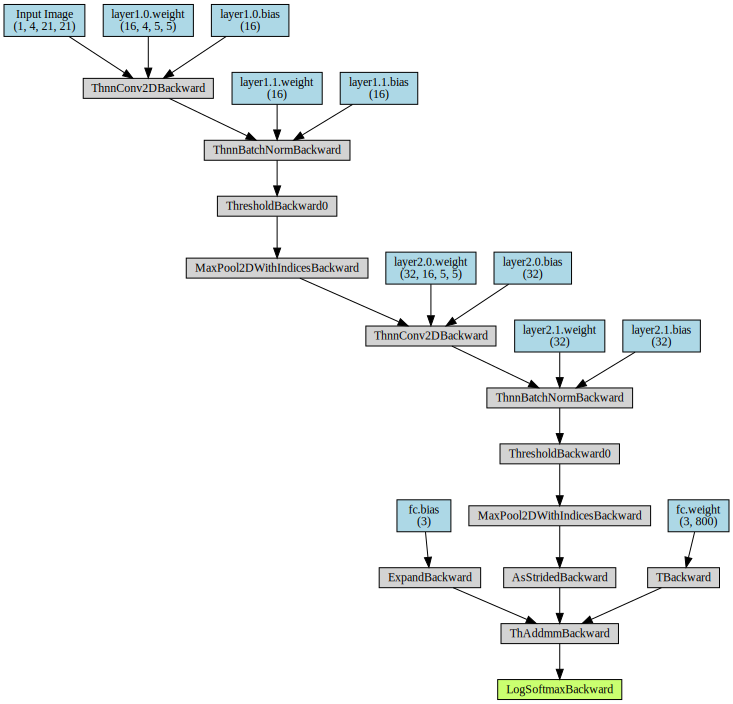

In [44]:
# Print the CNN architecture
model = ConvNet(3)

print(model)

x = torch.zeros(1, 4, 21, 21, dtype=torch.float, requires_grad=True)
out = model(x)
dot = make_dot(out, params=dict(list(model.named_parameters()) + [('Input Image', x)]))
dot.render('data/cnn_arch', format="png")
dot

In [37]:
def cnn_train_model(model, train_loader, test_loader, optimizer, EPOCH):
    model = model.to(DEVICE)

    if DEVICE == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    t0 = time.perf_counter()

    loss_train = np.zeros((EPOCH,))
    loss_test = np.zeros((EPOCH,))
    acc_test = np.zeros((EPOCH,))
    acc_train = np.zeros((EPOCH,))
    time_test = np.zeros((EPOCH,))

    bar = progressbar.ProgressBar(min_value=1, max_value=EPOCH)
    for epoch in range(EPOCH):
        bar.update(epoch+1)

        # train 1 epoch
        model.train()
        correct = 0
        train_loss = 0
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            loss = F.nll_loss(scores, b_y)      # negative log likelyhood
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            model.zero_grad()

            # computing training accuracy
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            train_loss += F.nll_loss(scores, b_y, reduction='sum').item()

        acc_train[epoch] = 100 * float(correct) / float(len(train_loader.dataset))
        loss_train[epoch] = train_loss / len(train_loader.dataset)

        # testing
        model.eval()
        correct = 0
        test_loss = 0
        for step, (x, y) in enumerate(test_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            test_loss += F.nll_loss(scores, b_y, reduction='sum').item()
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()

        loss_test[epoch] = test_loss/len(test_loader.dataset)
        acc_test[epoch] = 100 * float(correct) / float(len(test_loader.dataset))
        time_test[epoch] = time.perf_counter() - t0

    return [acc_train, acc_test, loss_train, loss_test, model]

In [11]:
def plot(acc_train, acc_test, loss_train, loss_test):
    print("Train Accuracy:", str(acc_train[-1]))
    print("Train Loss:", str(loss_train[-1]))
    print("Test Accuracy:", str(acc_test[-1]))
    print("Test Loss:", str(loss_test[-1]))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label='Acc. Train')
    plt.plot(acc_test, label='Acc. Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss_train, label='Loss Train')
    plt.plot(loss_test, label='Loss Test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()
    plt.clf()

In [12]:
def cnn_train_eval(level, model, eval_on="test", cnn_config={"lr": 0.001, "weight_decay": 0}, is_plot=True):
    # load train-test data and convert to a PyTorch Dataset of QRCode images
    train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels = load_train_val_test_data(
        level, analyze=False)
    train_loader = create_pytorch_datasets(seqeunces_to_image(train_sequences), train_labels)
    if eval_on == "test":
        eval_loader = create_pytorch_datasets(seqeunces_to_image(test_sequences), test_labels)
    elif eval_on == "val":
        eval_loader = create_pytorch_datasets(seqeunces_to_image(val_sequences), val_labels)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=cnn_config["lr"], weight_decay=cnn_config["weight_decay"])
    logs = cnn_train_model(model, train_loader, eval_loader, optimizer, EPOCH)
    
    if is_plot:
        plot(*logs[:-1])

    output = logs[:-1] + [{**cnn_config, **{"trained_model": logs[-1]}}]

    return output

100% (25 of 25) |########################| Elapsed Time: 0:01:58 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 4.6771322918492696e-05
Test Accuracy: 99.50953678474114
Test Loss: 0.024952048371858104


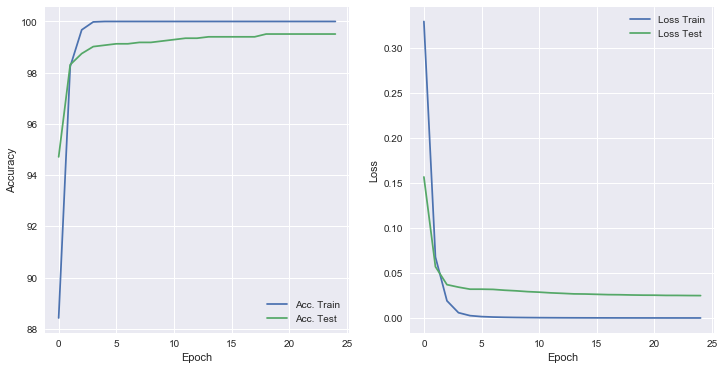

<Figure size 432x288 with 0 Axes>

In [17]:
logs = cnn_train_eval("phylum", ConvNet(3))

100% (25 of 25) |########################| Elapsed Time: 0:01:48 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 0.00019430473100307376
Test Accuracy: 97.76566757493188
Test Loss: 0.07485644563991951


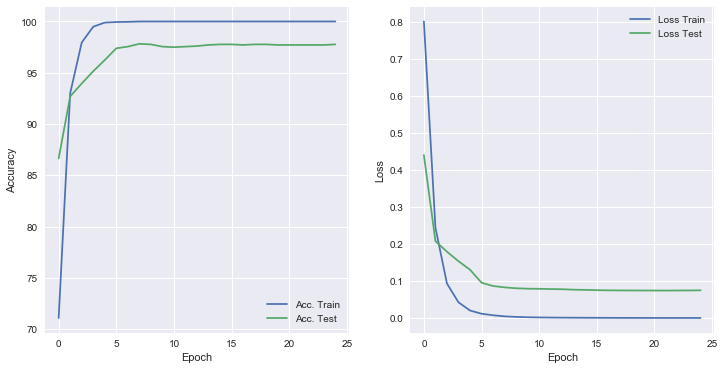

<Figure size 432x288 with 0 Axes>

In [18]:
logs = cnn_train_eval("class", ConvNet(5))

100% (25 of 25) |########################| Elapsed Time: 0:01:54 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 0.0007961693674672481
Test Accuracy: 94.44141689373296
Test Loss: 0.18344422315706674


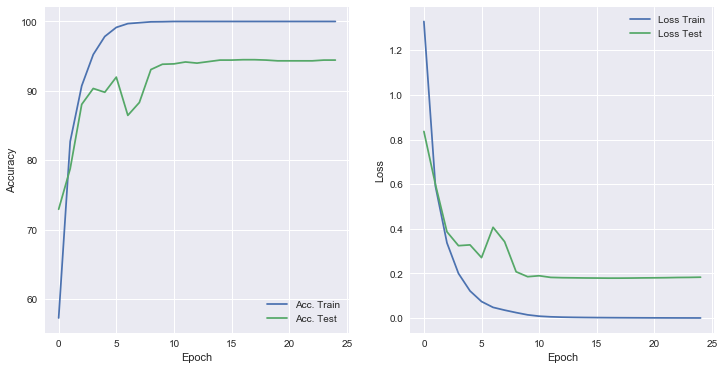

<Figure size 432x288 with 0 Axes>

In [19]:
logs = cnn_train_eval("order", ConvNet(10))